In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from neo4j import GraphDatabase
import json
# from py2neo import Graph
import random


In [2]:
bio_df = pd.read_excel('data/expression_data.xlsx', engine='openpyxl')



In [3]:
bio_df = bio_df.drop(bio_df.columns[0], axis=1)
proteins = bio_df.columns.tolist()


In [4]:
uniprot_to_reactome = pd.read_csv('data/MMU_Uniprot2Reactome.txt', sep='\t')

existing_proteins = uniprot_to_reactome[uniprot_to_reactome['V1'].isin(proteins)]['V1'].unique()

existing_proteins_list = existing_proteins.tolist()
len(existing_proteins_list)

1631

In [ ]:
existing_proteins_list


## queries that may be useful

```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel1]-()-[rel2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(DISTINCT rel1) + collect(DISTINCT rel2) AS relationships, collect(DISTINCT connectedNodes) AS nodes
```



```cypher
UNWIND $proteinNames AS proteinName
MATCH path = (p)-[*2]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) 
  AND connectedNodes.speciesName = 'Mus musculus' 
  AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, [r in relationships(path) | r] AS relationships, collect(DISTINCT connectedNodes) AS nodes
LIMIT 2
```




```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p))
  AND ANY(name IN p.name WHERE name = proteinName)
CALL apoc.path.subgraphAll(p, {
  maxLevel: 2,
  relationshipFilter: ">", // Adjust this based on your relationship types
  labelFilter: "/Mus musculus", // Adjust this to filter the end nodes, use + for include, - for exclude
  endNodeFilter: "Mus musculus" // This is not a native option, demonstrating intent
})
YIELD nodes, relationships
RETURN p AS protein, nodes, relationships
```





```cypher
UNWIND $proteinNames AS proteinName
MATCH (p)-[rel]-(connectedNodes)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p)) AND connectedNodes.speciesName = 'Mus musculus' AND ANY(name IN p.name WHERE name = proteinName)
RETURN p AS protein, collect(rel) AS relationships, collect(connectedNodes) AS nodes
```

# Extract connected nodes to the specific proteins from reactome using neo4j

In [118]:

def fetch_subgraphs(driver, protein_names):
    with driver.session() as session:
        result = session.run("""
UNWIND $proteinNames AS proteinName
MATCH (p)
WHERE ('EntityWithAccessionedSequence' IN labels(p) OR 'GenomeEncodedEntity' IN labels(p))
  AND ANY(name IN p.name WHERE name = proteinName)
CALL apoc.path.subgraphAll(p, {
  maxLevel: 2,
  minLevel:1,
  relationshipFilter: "<" 
})
YIELD nodes, relationships
WITH p, 
     [node in nodes WHERE 'Mus musculus' IN labels(node) OR node.speciesName = 'Mus musculus'] AS filteredNodes,
     relationships
RETURN p AS protein, filteredNodes AS nodes, relationships
        """, proteinNames=protein_names)
        return list(result)

def create_subgraph(record):
    subgraph = nx.MultiGraph()
    protein_node = record['protein']
    relationships = record['relationships']
    connected_nodes = record['nodes']
    
    # Add the protein node with its properties
    subgraph.add_node(protein_node.id, **protein_node._properties)
    
    # Add connected nodes and relationships
    for rel, node in zip(relationships, connected_nodes):
        subgraph.add_node(node.id, **node._properties)
        subgraph.add_edge(protein_node.id, node.id, **rel._properties)
    
    return subgraph





def combine_subgraphs(results):

    subgraphs = [create_subgraph(record) for record in results]
    

    aggregated_graph = nx.compose_all(subgraphs)
    
    return aggregated_graph

def convert_attributes_to_strings(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)):  
                G.nodes[node][key] = json.dumps(value)
    
    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (list, dict)): 
                G.edges[u, v][key] = json.dumps(value)


driver = GraphDatabase.driver("bolt://localhost:7688", auth=("neo4j", "123456789"))


subgraphs = fetch_subgraphs(driver, existing_proteins_list[:800])
aggregated_graph = combine_subgraphs(subgraphs)
convert_attributes_to_strings(aggregated_graph)
nx.write_graphml(aggregated_graph, "aggregated_proteins_v2.graphml")

driver.close()


/tmp/ipykernel_12428/2245311890.py:28: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_node(protein_node.id, **protein_node._properties)
/tmp/ipykernel_12428/2245311890.py:32: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_node(node.id, **node._properties)
/tmp/ipykernel_12428/2245311890.py:33: DeprecationWarning: `id` is deprecated, use `element_id` instead
  subgraph.add_edge(protein_node.id, node.id, **rel._properties)


# Find Connected Components

In [120]:
G = nx.read_graphml("aggregated_proteins_v2.graphml")

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


# Find connected components
connected_components = list(nx.connected_components(G))

# Print connected components
for i, component in enumerate(connected_components, 1):
    print(f"Component {i}: {component}")


source_node = "2085497"
hop_counts = nx.shortest_path_length(G, source=source_node)

# hop_counts is a dictionary where keys are target nodes and values are the number of hops
for target, hops in hop_counts.items():
    print(f"Number of hops from node {source_node} to node {target}: {hops}")


Number of nodes: 7776
Number of edges: 10380
Component 1: {'215300', '216675', '215292'}
Component 2: {'391403', '391409', '391394', '391395'}
Component 3: {'865942', '865954', '865945', '865939'}
Component 4: {'1067745', '1063378', '2260915', '1389651', '1392877', '542467', '1068140', '1389650', '1389747', '1389656', '1393010', '1064236', '1068025', '541719', '1392876', '575119', '576869', '1392881', '1063616', '1389655', '2260907', '1392880', '1393012', '1063334', '1392878', '502929', '575458', '1063593', '1068065', '1392873', '1390319', '1389654', '541484', '542704', '575124', '1393013', '575098', '1393008', '1390238', '1063009', '575164', '542159', '575496', '1063286', '1392875', '1392872', '575505', '1393007', '575432', '1066835', '542329', '542698', '1063340', '541810', '542690', '575525', '1390670', '1389657', '1063556', '1393014', '1392879', '1389739', '1389742', '1390239', '1067649', '575075', '2260680', '2260413'}
Component 5: {'1711623', '1907434', '817768', '1962293', '2069

# Random Walk with a restart using networkx pagerank function

In [121]:
G = nx.read_graphml("aggregated_proteins_v2.graphml")
# restart_nodes = [1]  # For example, restarting from node 1

# personalization = {node: 0.1 for node in G.nodes()}  # Starting value for all nodes
# for node in restart_nodes:
#     personalization[node] = 0.8  # Higher value for restart nodes

# pagerank_scores = nx.pagerank(G, personalization=personalization)

# print(pagerank_scores)

pagerank_scores = nx.pagerank(G)

# Number of nodes to sample
num_nodes_to_sample = 1000

# Sample nodes based on top PageRank scores
# Convert pagerank_scores to a list of tuples, sort by score, and select the top N
sampled_nodes_by_score = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:num_nodes_to_sample]
sampled_nodes_by_score = [node for node, score in sampled_nodes_by_score]

# Alternatively, sample nodes randomly
# Convert pagerank_scores keys (node names) to a list and sample randomly
all_nodes = list(pagerank_scores.keys())
sampled_nodes_randomly = random.sample(all_nodes, num_nodes_to_sample)

print("Sampled nodes based on top PageRank scores:", sampled_nodes_by_score)
# print("Sampled nodes randomly:", sampled_nodes_randomly)

Sampled nodes based on top PageRank scores: ['83121', '162116', '146816', '143275', '21115', '95703', '95699', '190730', '1519350', '1043669', '2259659', '413374', '1647857', '1306993', '610094', '422023', '1333810', '12882', '163634', '16757', '158963', '210526', '89690', '1361822', '606076', '1901822', '1325581', '470652', '624935', '396416', '166693', '430448', '184124', '192206', '1305597', '72873', '589972', '517845', '399008', '1000990', '285928', '288595', '1332859', '990133', '714233', '149034', '191202', '763063', '498289', '809915', '1005757', '1681202', '1920', '1306984', '1333803', '1316785', '51199', '1298883', '677479', '446915', '2226770', '348749', '400438', '170490', '943214', '942362', '698143', '677611', '119765', '1325377', '400445', '792475', '304601', '636289', '72563', '95551', '72134', '492475', '1908820', '1910195', '1912831', '1913173', '1913849', '658017', '750539', '482952', '502461', '94133', '1416632', '201270', '1713139', '1079333', '111839', '170212', '1

# Random Walk with restart

In [122]:
import networkx as nx
import random

def random_walk_with_restart(G, start_node, restart_prob=0.1, walk_length=10):
    """
    Performs a random walk with restart on a graph.

    Parameters:
    G: NetworkX graph
    start_node: Node to start the random walk from
    restart_prob: Probability of restarting the walk at the start node
    walk_length: The number of steps to take in the walk

    Returns:
    A list of nodes visited during the walk.
    """
    if start_node not in G:
        raise ValueError("Start node not in graph")

    walk = [start_node]
    current_node = start_node
    for _ in range(walk_length):
        if random.random() < restart_prob:
            current_node = start_node
        else:
            neighbors = list(G.neighbors(current_node))
            if neighbors:
                current_node = random.choice(neighbors)
            else:
                # No neighbors to move to
                break
        walk.append(current_node)
    return walk
    # return graph.subgraph(walk)



G = nx.read_graphml("aggregated_proteins_v2.graphml")
walk = random_walk_with_restart(G, start_node='2235550', restart_prob=0.3, walk_length=100)
print(walk)
# visualize_graph(walk)

['2235550', '2227100', '2236086', '990133', '2243788', '1315965', '2235550', '2235550', '2235550', '2235550', '2227100', '2235550', '2234277', '2234490', '2233608', '2240004', '751378', '2240046', '2235550', '2227100', '2236086', '1713139', '2236086', '2227100', '2240257', '2227100', '2228016', '990133', '2235550', '1943034', '1943086', '2235550', '1943034', '2235550', '2234277', '2235550', '2234277', '2235550', '2227100', '2227913', '2227100', '2240257', '2227100', '2227913', '2235550', '1943034', '1943086', '2235550', '1943034', '2235550', '2231838', '2231871', '1713139', '2235550', '1943034', '2235550', '2234277', '2235550', '2235550', '2235550', '2235550', '2231838', '2234862', '990133', '2231871', '2226770', '2234514', '2234044', '2234514', '2234044', '2234479', '2235550', '1943034', '1943096', '1943034', '2235550', '2227100', '2228016', '990133', '2248727', '990133', '2243788', '2226770', '2233165', '990133', '2242158', '2235550', '2234277', '2235550', '2231838', '2234862', '1713

# Forest Fire Sampling

In [123]:
def forest_fire_sampling(graph, num_nodes, starting_node=None, p=0.7, restart=True):
    """
    Performs the forest fire sampling on the given graph, aiming to sample a specified number of nodes.

    Parameters:
    - graph: The graph on which to perform the sampling.
    - num_nodes: The desired number of nodes to sample.
    - starting_node: The node from where to start the fire. If None, a random node is chosen.
    - p: The probability of each neighbor being "burned" (visited).
    - restart: Whether to restart the fire from another node if it extinguishes and the desired number of nodes hasn't been reached.

    Returns:
    A subgraph representing the sampled nodes and edges.
    """
    if starting_node is None:
        starting_node = random.choice(list(graph.nodes))
    
    sampled_nodes = set([starting_node])
    frontier = [starting_node]

    while frontier and len(sampled_nodes) < num_nodes:
        new_frontier = []
        for node in frontier:
            if len(sampled_nodes) >= num_nodes:
                break  # Stop if we have reached or exceeded the desired number of sampled nodes
            
            neighbors = list(graph.neighbors(node))
            for neighbor in neighbors:
                if neighbor not in sampled_nodes and random.random() < p:
                    sampled_nodes.add(neighbor)
                    new_frontier.append(neighbor)
                    if len(sampled_nodes) >= num_nodes:
                        break  # Stop if we have reached the desired number of sampled nodes

        frontier = new_frontier
        
        # If no new frontier nodes and we haven't reached the desired number of nodes, consider restarting
        if not frontier and restart and len(sampled_nodes) < num_nodes:
            remaining_nodes = list(set(graph.nodes) - sampled_nodes)
            if remaining_nodes:
                new_start = random.choice(remaining_nodes)
                frontier.append(new_start)
                sampled_nodes.add(new_start)

    return graph.subgraph(sampled_nodes)


def read_graph_from_graphml(file_path):
    return nx.read_graphml(file_path)

def visualize_graph(graph):
    nx.draw(graph, node_color='lightblue', edge_color='gray')
    plt.show()

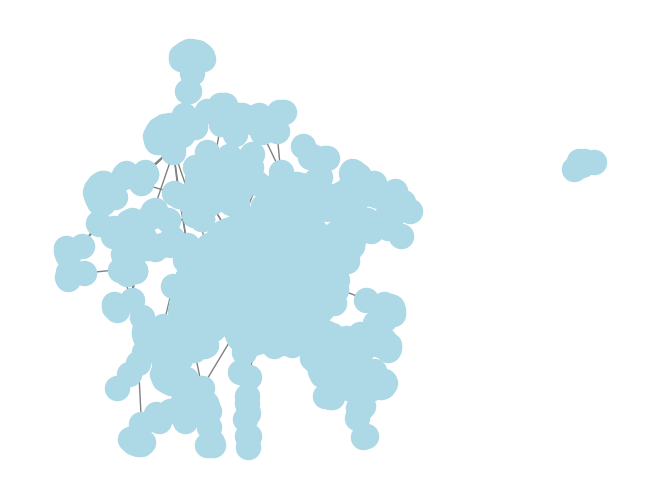

Sampled Nodes: Graph with 1000 nodes and 1852 edges


In [124]:
# sampled_nodes = forest_fire_sampling("aggregated_proteins_v2.graphml",burn_prob=0.8)


graph = read_graph_from_graphml("aggregated_proteins_v2.graphml")
sampled_graph = forest_fire_sampling(graph,1000, p=0.7, restart=True)
visualize_graph(sampled_graph)
print("Sampled Nodes:", sampled_graph)


# Cluster-GCN

In [1]:
# import networkx as nx
# from torch_geometric.utils import from_networkx

# G = nx.read_graphml('aggregated_proteins_v2.graphml')

# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)


In [1]:
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
import numpy as np

G = nx.read_graphml('aggregated_proteins_v2.graphml')


def preprocess_features(features):
    # Convert features to a numeric format, handle non-numeric cases
    processed_features = []
    for feature in features:
        try:
            # convert the features to float
            processed_features.append(float(feature))
        except ValueError:
            # Handle non-numeric feature (could implement encoding here)
            processed_features.append(0.0)  # Using 0.0 as a placeholder
    return processed_features

def normalize_features(features):
    features = np.array(features)
    mean = features.mean(axis=0, keepdims=True)
    std = features.std(axis=0, keepdims=True)
    # Avoid division by zero
    std[std == 0] = 1
    normalized_features = (features - mean) / std
    return normalized_features.tolist()

def from_networkx_to_torch_geometric(G):
    # Convert node indices to a continuous range
    mapping = {k: i for i, k in enumerate(G.nodes())}
    edges = torch.tensor([list(map(mapping.get, edge)) for edge in G.edges()], dtype=torch.long).t().contiguous()
    
    if G.nodes():
        # Extract a sample node to get feature keys (assumes at least one node exists)
        sample_features = next(iter(G.nodes(data=True)))[1]
        feature_keys = list(sample_features.keys())
        
        # Extract and preprocess features for all nodes
        features = []
        for _, node_features in G.nodes(data=True):
            node_feature_values = [node_features.get(key, 0) for key in feature_keys]
            processed_features = preprocess_features(node_feature_values)
            features.append(processed_features)
        
        # Normalize features
        features = normalize_features(features)
    else:
        # Default to a single feature of 0 if no nodes or features
        features = [[0]]

    # Convert features to a tensor
    x = torch.tensor(features, dtype=torch.float)

    # Create the Data object
    data = Data(x=x, edge_index=edges)
    
    return data

def create_masks_for_node_classification(data, train_percent=0.6, val_percent=0.2):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_percent)
    num_val = int(num_nodes * val_percent)

    # Shuffle node indices
    indices = torch.randperm(num_nodes)

    # Assign masks
    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[indices[:num_train]] = True
    data.val_mask[indices[num_train:num_train + num_val]] = True
    data.test_mask[indices[num_train + num_val:]] = True

    return data


    
# node_attrs = set()
# for _, node_data in G.nodes(data=True):
#     node_attrs.update(node_data.keys())

# # Initialize missing attributes with None or a default value
# for _, node_data in G.nodes(data=True):
#     for attr in node_attrs:
#         if attr not in node_data:
#             node_data[attr] = None  # or some default value

# data = from_networkx(G)

data = from_networkx_to_torch_geometric(G)
# data = create_masks_for_node_classification(data)

# Creating a custom dataset
class CustomGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CustomGraphDataset, self).__init__()
        self.data_list = data_list
    
    def len(self):
        return len(self.data_list)
    
    def get(self, idx):
        return self.data_list[idx]

# Assuming you have a list of Data objects, you can create a dataset like this:
dataset = CustomGraphDataset([data])

# Example usage
loader = DataLoader(dataset, batch_size=1, shuffle=True)

print(data)

Data(x=[7776, 11], edge_index=[2, 10380])


In [6]:
from torch_geometric.loader import ClusterData
from torch_geometric.loader import ClusterLoader

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = data.to(device)
torch.manual_seed(12345)
# Prepare cluster data
cluster_data = ClusterData(data, num_parts=8, recursive=True) 
# Create a loader to iterate over clusters
loader = ClusterLoader(cluster_data, batch_size=1, shuffle=True)  

print()
total_num_nodes = 0
for step, sub_data in enumerate(loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')



Step 1:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 854])

Step 2:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 568])

Step 3:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 838])

Step 4:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 714])

Step 5:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 562])

Step 6:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 673])

Step 7:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 819])

Step 8:
Number of nodes in the current batch: 972
Data(x=[972, 11], edge_index=[2, 468])

Iterated over 7776 of 7776 nodes!


Computing METIS partitioning...
Done!


In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphAutoencoder(torch.nn.Module):
    def __init__(self, num_features, embedding_dim=64):
        super(GraphAutoencoder, self).__init__()
        self.encoder_conv1 = GCNConv(num_features, embedding_dim)
        self.encoder_conv2 = GCNConv(embedding_dim, embedding_dim)
        self.decoder_lin = torch.nn.Linear(embedding_dim, num_features)
    
    def forward(self, x, edge_index):
        x = F.relu(self.encoder_conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        encoded = F.relu(self.encoder_conv2(x, edge_index))
        decoded = self.decoder_lin(encoded)
        return encoded, decoded




In [8]:
print("Number of batches in loader:", len(loader))
for batch_idx, cluster in enumerate(loader):
    print(f"Batch {batch_idx} contains {cluster.num_nodes} nodes.")


Number of batches in loader: 8
Batch 0 contains 972 nodes.
Batch 1 contains 972 nodes.
Batch 2 contains 972 nodes.
Batch 3 contains 972 nodes.
Batch 4 contains 972 nodes.
Batch 5 contains 972 nodes.
Batch 6 contains 972 nodes.
Batch 7 contains 972 nodes.


In [11]:
num_epochs = 1000

reconstruction_loss_fn = torch.nn.MSELoss()

model = GraphAutoencoder(num_features=11, embedding_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)




for epoch in range(num_epochs):  
    model.train()
    total_loss = 0
    for batch_idx, cluster in enumerate(loader):
        optimizer.zero_grad()
        _, reconstructed = model(cluster.x, cluster.edge_index)  # Get the reconstructed node features
        loss = reconstruction_loss_fn(reconstructed, cluster.x)  # Compare with original features
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch}, Average Loss: {avg_loss}")
    # print(f"Batch {cluster}, Loss: {loss.item()}")


Epoch 0, Average Loss: 0.18741116672754288
Epoch 1, Average Loss: 0.1362426346167922
Epoch 2, Average Loss: 0.13300116825848818
Epoch 3, Average Loss: 0.12210327293723822
Epoch 4, Average Loss: 0.12680452037602663
Epoch 5, Average Loss: 0.11884150188416243
Epoch 6, Average Loss: 0.1147753270342946
Epoch 7, Average Loss: 0.11458119656890631
Epoch 8, Average Loss: 0.11269155517220497
Epoch 9, Average Loss: 0.10836071707308292
Epoch 10, Average Loss: 0.10941473860293627
Epoch 11, Average Loss: 0.10621050372719765
Epoch 12, Average Loss: 0.11044573877006769
Epoch 13, Average Loss: 0.10884674452245235
Epoch 14, Average Loss: 0.11243407614529133
Epoch 15, Average Loss: 0.10519450437277555
Epoch 16, Average Loss: 0.10484104696661234
Epoch 17, Average Loss: 0.1047139773145318
Epoch 18, Average Loss: 0.10790256969630718
Epoch 19, Average Loss: 0.1057188743725419
Epoch 20, Average Loss: 0.10138185042887926
Epoch 21, Average Loss: 0.1010373467579484
Epoch 22, Average Loss: 0.09993294812738895
Epo

# Extra codes

In [14]:
import torch
from torch_geometric.data import Data
import networkx as nx

def to_pyg_graph(G):
    # Convert edges to a list of tuples of integer node indices
    edge_index = torch.tensor([(u, v) for u, v in G.edges()], dtype=torch.long).t().contiguous()

    # Example for adding node features (modify as needed)
    x = torch.tensor([G.nodes[n].get('features', [0]) for n in G.nodes], dtype=torch.float)
    
    # Create the Data object
    data = Data(x=x, edge_index=edge_index)
    
    return data


In [27]:
from torch_geometric.data import Dataset

class CustomGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(CustomGraphDataset, self).__init__(root, transform, pre_transform)
        # self.data = torch.load(self.processed_paths[0])
        self.data_list = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        # Return a list of files in `self.raw_dir` which need to be found in order to skip the download.
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    # def download(self):
    #     # Download to `self.raw_dir`.

    def process(self):
        # Read data into huge `Data` list.
        G = nx.read_graphml('aggregated_proteins_v2.graphml')
        G = nx.convert_node_labels_to_integers(G)
        data_list = [to_pyg_graph(G)]

        # If there's a pre-transform, apply it
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]
    
        # Save the list of Data objects
        torch.save(data_list, self.processed_paths[0])
        


    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


In [38]:
from torch_geometric.loader import DataLoader

# Assuming 'CustomGraphDataset' is your dataset class
dataset = CustomGraphDataset(root='')

# Use the DataLoader to handle batching
loader = DataLoader(dataset, batch_size=32, shuffle=True)

train_features = next(iter(loader))
print(train_features)

DataBatch(x=[4419, 1], edge_index=[2, 5303], batch=[4419], ptr=[2])


# Stellargraph

In [2]:
# Print information about the graph (optional)
print(f"Loaded graph with {g.vcount()} nodes and {g.ecount()} edges.")

g.vs.attribute_names()
node_types = g.vs['schemaClass']
unique_node_types = set(node_types)
print("Unique Node Types:", unique_node_types)

NameError: name 'g' is not defined

In [3]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

In [4]:
import networkx as nx
from stellargraph import StellarGraph

# Load the graph from a GraphML file
nx_graph = nx.read_gml('agg.gml')

# Convert the NetworkX graph to a StellarGraph object.
stellargraph = StellarGraph.from_networkx(nx_graph)
stellargraph.info()

'StellarGraph: Undirected multigraph\n Nodes: 2649, Edges: 2159\n\n Node types:\n  default: [2649]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [2159]\n        Weights: all 1 (default)\n        Features: none'

In [5]:
hinsage_generator = HinSAGENodeGenerator(
    stellargraph, batch_size=1000, num_samples=[5]
)

hinsage_model = HinSAGE(
    layer_sizes=[128], activations=["relu"], generator=hinsage_generator
)
hinsage_acc = run_deep_graph_infomax(hinsage_model, hinsage_generator, epochs=epochs)

print(f"Test classification accuracy: {hinsage_acc}")

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning